In [10]:
import pandas as pd
from rdkit import Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit import RDLogger
import numpy as np
import time
import func_timeout
RDLogger.DisableLog('rdApp.*')

In [11]:
def extract_template(rxn_smiles,max_prec):
    import rdchiral
    from rdchiral import template_extractor
    templates = []
    for i in index[0:max_prec]:
        rxnmapped = rxn_smiles[i]
        reaction = {
        'reactants': rxnmapped.split('>')[0],
        'products': rxnmapped.split('>')[-1],
        '_id': i,
        }
        template = template_extractor.extract_from_reaction(reaction)
        templates.append(template)
    #print(templates)
    #print(len(templates))
    #display(templates[0]['reaction_smarts'])
    #print('---------------------------')
    rxn_template = []
    n = 0
    for i in templates:
        if i is None or 'reaction_smarts' not in i:
            rxn_smarts = None
            n += 1
            #print(rxn_smarts)
            #print(i['reaction_id'])
            rxn_template.append(rxn_smarts)
            continue
        rxn_smarts = '(' + i['reaction_smarts'].replace('>>', ')>>')
        #print(rxn_smarts)
        #print(i['reaction_id'])
        rxn_template.append(rxn_smarts)
    #print(len(rxn_template))
    #print("number of invalid templates is %d" %n)
    return(rxn_template)

In [12]:
@func_timeout.func_set_timeout(20) 
def get_precru(i, rct, combine_enantiomers=False):
    from rdchiral.main import rdchiralRun
    return rdchiralRun(i, rct, combine_enantiomers=combine_enantiomers)

def propose_precursors(rxn_templates):
    from rdkit.Chem import rdChemReactions
    from rdchiral.main import rdchiralReactants, rdchiralReaction, rdchiralRun
    rct = rdchiralReactants(product_smiles)
    rxns = []
    precursors = []
    n=0
    for i in rxn_templates: 
        if i is None:
            #print('------------------------------')
            #print("invalid rxn_template")
            #print('------------------------------')
            rxn = None
            rxns.append(rxn)
            continue
        rxn_i = AllChem.ReactionFromSmarts(i)
        #num_r = rxn_i.GetNumReactantTemplates()
        #num_p = rxn_i.GetNumProductTemplates()
        #n += 1
        #print(num_r, num_p, n)
        #print('------------------------------')
        rxn = rdchiralReaction(i)
        rxns.append(rxn)
        #print(rxns)
    #print('##############################')
    for i in rxns:
        if i is None:
            precursor = None
            precursors.append(precursor)
            #print(precursor)
            continue
        
        try:
            precursor = get_precru(i, rct, combine_enantiomers=False)
        except:
            precursor = None
        precursors.append(precursor)

        # print(precursor)
    #print(len(precursors))
    return(precursors)

In [13]:
def get_rxns():
    rxns =[]
    coindexs = []
    for idx,i in enumerate(precursors):
        if i is None:
            rxnstr = None
            rxns.append(rxnstr)
            coindex = index[idx]
            coindexs.append(coindex)
            #print('------------------------------')
            #print("this reaction could not propose suitable smiles")
            #print('------------------------------')
            continue
        if len(i) ==0:
            rxnstr = None
            rxns.append(rxnstr)
            coindex = index[idx]
            coindexs.append(coindex)
            #print('------------------------------')
            #print("this reaction could not propose suitable smiles")
            #print('------------------------------')
            continue
        for j in i:
            m = Chem.MolFromSmiles(j,sanitize=False)
            if m is None:
                print('invalid smiles')
                rxnstr = None
                rxns.append(rxnstr)
                coindex = index[idx]
                coindexs.append(coindex)
            else:
                try:
                    Chem.SanitizeMol(m)
                    #print("smiles is ok")
                    #display(m)
                    rxnstr=j +'>>'+product_smiles
                    #print(rxnstr)
                    rxns.append(rxnstr)
                    coindex = index[idx]
                    coindexs.append(coindex)

                except:
                    #print('invalid chemistry')
                    rxnstr = None
                    rxns.append(rxnstr)
                    coindex = index[idx]
                    coindexs.append(coindex) 
    #print(rxns)
    #print(len(rxns))
    #print(coindexs)
    #print(len(coindexs))
    repeat_indexs = []
    t = {}
    for i in range(len(coindexs)):
        for j in range(i):
             if coindexs[i] == coindexs[j]:
                repeat_index = coindexs[j]
                #print(repeat_index)
                repeat_indexs.append(repeat_index)
    #print('------------------------------')
    t = list(zip(coindexs,rxns))
    #print(t)
    #print(len(t))
    return rxns,t

In [14]:
def remove_reactant_smiles():
    Reactant_smiles = []
    Reactant_mols = []
    for rxn_smi in df['Rxn']:
        rcts_smi = rxn_smi.split('>>')[0]
        rcts_mol = Chem.MolFromSmiles(rcts_smi)
        [atom.ClearProp('molAtomMapNumber') for atom in rcts_mol.GetAtoms()]
        Reactant_smile = Chem.MolToSmiles(rcts_mol, True)
        Reactant_smiles.append(Reactant_smile)
        Reactant_mol = Chem.MolFromSmiles(Reactant_smile, True)
        Reactant_mols.append(Reactant_mol) 
    return(Reactant_mols)

In [15]:
def rank():
    s_reacs =[]
    ss=[]
    for x in index:
        for k,v in t:
            if k == x:
                #print(k)

                if v is None:
                    #print(v)
                    s_reac = 0
                    s_reacs.append(s_reac)
                    s = 0
                    ss.append(s)
                    continue
                else:
                    i = str(v).split('>>')[0]
                    #print(i)
                    Proposal_mol = Chem.MolFromSmiles(i)
                    if Proposal_mol is None:
                        s_reac = 0
                        s_reacs.append(s_reac)
                        s = 0
                        ss.append(s)
                        continue
                    mfp_proposal = AllChem.GetMorganFingerprint(Proposal_mol,2,useFeatures=True)
                    mfp_Reactant_mol = AllChem.GetMorganFingerprint(Reactant_mols[x],2,useFeatures=True)
                    s_reac = DataStructs.TanimotoSimilarity(mfp_Reactant_mol, mfp_proposal)
                    s_reacs.append(s_reac)
                    s = s_reac*s_prods[x]
                    ss.append(s)
    #print(ss)
    order = np.argsort(ss)[::-1]
    #print(order)
    #print(len(ss))
    return(order)

In [16]:
def remove_atom_mapping():
    df_1=pd.read_csv("data_test_reaxys.csv",encoding="gbk")
    remove_prod_smiles = []
    remove_rcts_smiles = []
    remove_rxns_smiles = []

    for rxn_smi in df_1['Rxn']:
        prod_smi = rxn_smi.split('>>')[-1]
        prod_mol = Chem.MolFromSmiles(prod_smi)
        [atom.ClearProp('molAtomMapNumber') for atom in prod_mol.GetAtoms()]
        prod_smi_remove_atom_map = Chem.MolToSmiles(prod_mol, True)
        prod_smi_remove_atom_map = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smi_remove_atom_map), True)
        remove_prod_smiles.append(prod_smi_remove_atom_map)      
    for rxn_smi in df_1['Rxn']:
        rcts_smi = rxn_smi.split('>>')[0]
        rcts_mol = Chem.MolFromSmiles(rcts_smi)
        [atom.ClearProp('molAtomMapNumber') for atom in rcts_mol.GetAtoms()]
        rcts_smi_remove_atom_map = Chem.MolToSmiles(rcts_mol, True)
        # Sometimes stereochem takes another canonicalization...
        rcts_smi_remove_atom_map = Chem.MolToSmiles(Chem.MolFromSmiles(rcts_smi_remove_atom_map), True)
        remove_rcts_smiles.append(rcts_smi_remove_atom_map)            

        rxn_smi_remove_atom_map = rcts_smi_remove_atom_map + '>>' + prod_smi_remove_atom_map
        remove_rxns_smiles.append(rxn_smi_remove_atom_map) 
    #print(remove_prod_smiles)
    #print('***********************')
    #print(remove_rcts_smiles)
    #print('***********************')
    #print(remove_rxns_smiles)    
    dataframe_test_remove = pd.DataFrame({'Product':remove_prod_smiles[:],'Reactant':remove_rcts_smiles[:],'Rxn':remove_rxns_smiles[:]})
    dataframe_test_remove.to_csv('remove_data_test_reaxys.csv',index=False)
    return()

In [17]:
def get_accuracy(n):
    accuracy = []
    m = 0
    for i,j in enumerate(order):
        if i < n:
            if rxns[j] is None:
                continue
            x = rxns[j].split('>>')[0]
            if x == true_precursors:
                display(Chem.MolFromSmiles(x))
                a = np.zeros(i,dtype = int)
                b = np.ones(n-i,dtype = int)
                accuracy = np.concatenate((a,b))
                #print(accuracy)
                m = m +1
                #print(m)
                break
        else:
            break
    if m == 0:
        accuracy = np.zeros(n,dtype = int)
        #print(accuracy)
    return(accuracy)

In [18]:
#prepare_data
import random
data_1=pd.read_csv("data_processed.csv",encoding="gbk")
products_1 = list(data_1['prod_smiles'])
mapped_rxns_1 = list(data_1['rxn_smiles'])
data_2=pd.read_csv("data_train_reaxys.csv",encoding="gbk")
products_2 = list(data_2['Product'])
mapped_rxns_2 = list(data_2['Rxn'])

for i in range(len(products_1)):
    if i >= len(products_1):
        continue
    if Chem.MolFromSmiles(products_1[i]) == None:
        del products_1[i]
        del mapped_rxns_1[i]
        
for i in range(len(products_2)):
    if i >= len(products_2):
        continue
    if Chem.MolFromSmiles(products_2[i]) == None:
        del products_2[i]
        del mapped_rxns_2[i]

products = products_1 + products_2
mapped_rxns = mapped_rxns_1 + mapped_rxns_2
random.seed(152)
random.shuffle(products)
random.shuffle(mapped_rxns)

dataframe = pd.DataFrame({'Product':products,'Rxn':mapped_rxns})
dataframe.to_csv('data_train_USPTO+Reaxys.csv',index=False)

In [19]:
print('Starting......')
start_time = time.time()
#train:smiles2mol2fingerprint
Product_mols = []
df=pd.read_csv("data_train_USPTO+Reaxys.csv",encoding="gbk")
for i in df['Product']:
    Product_mol = Chem.MolFromSmiles(i)
    Product_mols.append(Product_mol)
mfps = []
for i in Product_mols:
    mfp = AllChem.GetMorganFingerprint(i,2,useFeatures=True)
    mfps.append(mfp)


Starting......


total length:  1086
( 1  /  1086 )...... Spent time: 75.08669805526733
0 %,  accuracy: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
( 2  /  1086 )...... Spent time: 6.002774715423584
( 3  /  1086 )...... Spent time: 8.188704252243042
( 4  /  1086 )...... Spent time: 5.897954225540161
( 5  /  1086 )...... Spent time: 7.2721240520477295
( 6  /  1086 )...... Spent time: 5.94484806060791
( 7  /  1086 )...... Spent time: 6.057280540466309
( 8  /  1086 )...... Spent time: 6.13240647315979
( 9  /  1086 )...... Spent time: 6.223734140396118
( 10  /  1086 )...... Spent time: 6.137700796127319
( 11  /  1086 )...... Spent time: 5.913990020751953
( 12  /  1086 )...... Spent time: 5.993537664413452
( 13  /  1086 )...... Spent time: 6.020761728286743
( 14  /  1086 )...... Spent time: 5.9578046798706055
( 15  /  1086 )...... Spent time: 6.0783257484436035


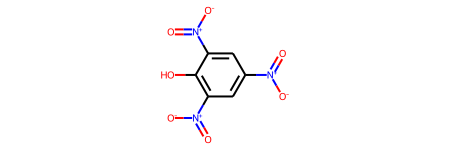

( 16  /  1086 )...... Spent time: 6.332225561141968
( 17  /  1086 )...... Spent time: 6.246870279312134
( 18  /  1086 )...... Spent time: 6.833065748214722
( 19  /  1086 )...... Spent time: 6.195988416671753
( 20  /  1086 )...... Spent time: 5.9951536655426025
( 21  /  1086 )...... Spent time: 5.8539817333221436
( 22  /  1086 )...... Spent time: 6.636147737503052
( 23  /  1086 )...... Spent time: 5.864141464233398
( 24  /  1086 )...... Spent time: 5.999491930007935
( 25  /  1086 )...... Spent time: 6.670624732971191
( 26  /  1086 )...... Spent time: 6.038241147994995
( 27  /  1086 )...... Spent time: 6.478336811065674
( 28  /  1086 )...... Spent time: 5.829038143157959
( 29  /  1086 )...... Spent time: 6.011722803115845
( 30  /  1086 )...... Spent time: 6.319825649261475
( 31  /  1086 )...... Spent time: 6.103857517242432
( 32  /  1086 )...... Spent time: 6.37227463722229
( 33  /  1086 )...... Spent time: 6.015021562576294
( 34  /  1086 )...... Spent time: 6.067267656326294
( 35  /  10

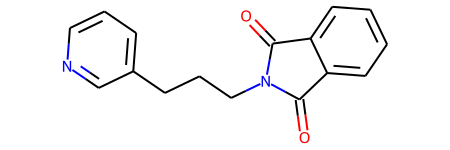

( 37  /  1086 )...... Spent time: 6.15097188949585
( 38  /  1086 )...... Spent time: 6.083822965621948
( 39  /  1086 )...... Spent time: 6.4746479988098145
( 40  /  1086 )...... Spent time: 5.676299810409546
( 41  /  1086 )...... Spent time: 5.845643997192383
( 42  /  1086 )...... Spent time: 5.929344415664673
( 43  /  1086 )...... Spent time: 6.270170211791992
( 44  /  1086 )...... Spent time: 6.0669896602630615
( 45  /  1086 )...... Spent time: 6.240235328674316
( 46  /  1086 )...... Spent time: 6.344128847122192
( 47  /  1086 )...... Spent time: 5.910505533218384
( 48  /  1086 )...... Spent time: 6.326368093490601
( 49  /  1086 )...... Spent time: 7.958548307418823
( 50  /  1086 )...... Spent time: 6.136479616165161
( 51  /  1086 )...... Spent time: 5.723378419876099
( 52  /  1086 )...... Spent time: 6.331380605697632
( 53  /  1086 )...... Spent time: 7.725449085235596
( 54  /  1086 )...... Spent time: 6.013861656188965
( 55  /  1086 )...... Spent time: 6.459068059921265
5 %,  accur

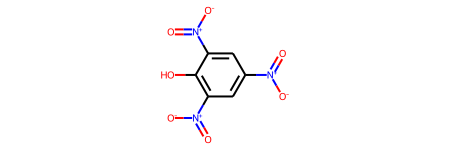

( 208  /  1086 )...... Spent time: 5.708355903625488
( 209  /  1086 )...... Spent time: 6.707931280136108
( 210  /  1086 )...... Spent time: 5.814393043518066
( 211  /  1086 )...... Spent time: 9.985949516296387
( 212  /  1086 )...... Spent time: 5.488046646118164
( 213  /  1086 )...... Spent time: 5.716706991195679
( 214  /  1086 )...... Spent time: 5.9824347496032715
( 215  /  1086 )...... Spent time: 5.624600410461426
( 216  /  1086 )...... Spent time: 6.371887445449829
( 217  /  1086 )...... Spent time: 5.94678258895874
20 %,  accuracy: [0.00921659 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488
 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488
 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488
 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488
 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488
 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488 0.01382488
 0.01382488 0.01382488 0.01382488 0.01382488 0.0138

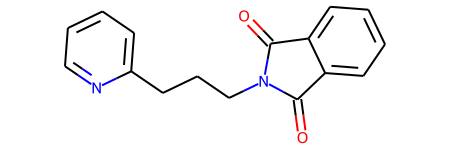

( 353  /  1086 )...... Spent time: 6.143928527832031
( 354  /  1086 )...... Spent time: 6.201751232147217
( 355  /  1086 )...... Spent time: 5.835755825042725
( 356  /  1086 )...... Spent time: 6.016096830368042
( 357  /  1086 )...... Spent time: 6.3800389766693115
( 358  /  1086 )...... Spent time: 6.623923301696777
( 359  /  1086 )...... Spent time: 5.627644062042236
( 360  /  1086 )...... Spent time: 5.9306089878082275
( 361  /  1086 )...... Spent time: 5.839205026626587
( 362  /  1086 )...... Spent time: 6.285850286483765
( 363  /  1086 )...... Spent time: 5.873690605163574
( 364  /  1086 )...... Spent time: 5.902590036392212
( 365  /  1086 )...... Spent time: 6.81122088432312
( 366  /  1086 )...... Spent time: 6.039139747619629
( 367  /  1086 )...... Spent time: 5.713534116744995
( 368  /  1086 )...... Spent time: 5.768753290176392
( 369  /  1086 )...... Spent time: 5.514312267303467
( 370  /  1086 )...... Spent time: 9.366262674331665
( 371  /  1086 )...... Spent time: 5.78129887

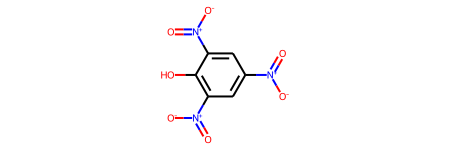

( 678  /  1086 )...... Spent time: 6.033533811569214
( 679  /  1086 )...... Spent time: 5.706744432449341
( 680  /  1086 )...... Spent time: 5.6361377239227295
( 681  /  1086 )...... Spent time: 6.242910146713257
( 682  /  1086 )...... Spent time: 5.71619176864624
( 683  /  1086 )...... Spent time: 5.667257070541382
( 684  /  1086 )...... Spent time: 5.783031463623047
( 685  /  1086 )...... Spent time: 5.924057483673096
( 686  /  1086 )...... Spent time: 7.914564371109009
( 687  /  1086 )...... Spent time: 5.725755214691162
( 688  /  1086 )...... Spent time: 6.125138998031616
( 689  /  1086 )...... Spent time: 6.872139930725098
( 690  /  1086 )...... Spent time: 6.051865816116333
( 691  /  1086 )...... Spent time: 5.6089768409729
( 692  /  1086 )...... Spent time: 5.753232002258301
( 693  /  1086 )...... Spent time: 6.1365885734558105
( 694  /  1086 )...... Spent time: 5.798954010009766
( 695  /  1086 )...... Spent time: 6.058525562286377
( 696  /  1086 )...... Spent time: 5.6715998649

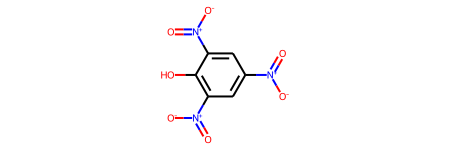

( 818  /  1086 )...... Spent time: 5.872767210006714
( 819  /  1086 )...... Spent time: 9.00369381904602
( 820  /  1086 )...... Spent time: 6.124444007873535
( 821  /  1086 )...... Spent time: 5.747643709182739
( 822  /  1086 )...... Spent time: 5.706131219863892
( 823  /  1086 )...... Spent time: 6.0225136280059814
( 824  /  1086 )...... Spent time: 5.895978927612305
( 825  /  1086 )...... Spent time: 5.886760473251343
( 826  /  1086 )...... Spent time: 5.800546169281006
( 827  /  1086 )...... Spent time: 6.242645978927612
( 828  /  1086 )...... Spent time: 5.673669815063477
( 829  /  1086 )...... Spent time: 5.873186111450195
( 830  /  1086 )...... Spent time: 5.966242790222168
( 831  /  1086 )...... Spent time: 7.824998617172241
( 832  /  1086 )...... Spent time: 5.657431125640869
( 833  /  1086 )...... Spent time: 5.685039520263672
( 834  /  1086 )...... Spent time: 5.656514406204224
( 835  /  1086 )...... Spent time: 5.7396180629730225
( 836  /  1086 )...... Spent time: 6.12498521

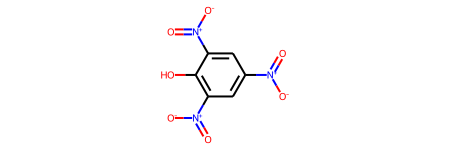

( 940  /  1086 )...... Spent time: 5.823932647705078
( 941  /  1086 )...... Spent time: 5.567599534988403
( 942  /  1086 )...... Spent time: 5.673060178756714
( 943  /  1086 )...... Spent time: 5.907887935638428
( 944  /  1086 )...... Spent time: 6.452808380126953
( 945  /  1086 )...... Spent time: 5.803421497344971
( 946  /  1086 )...... Spent time: 5.622879266738892
( 947  /  1086 )...... Spent time: 5.844719171524048
( 948  /  1086 )...... Spent time: 5.97547459602356
( 949  /  1086 )...... Spent time: 5.784156560897827
( 950  /  1086 )...... Spent time: 5.729418039321899
( 951  /  1086 )...... Spent time: 5.4845054149627686
( 952  /  1086 )...... Spent time: 5.89288067817688
( 953  /  1086 )...... Spent time: 5.879281044006348
( 954  /  1086 )...... Spent time: 5.79210638999939
( 955  /  1086 )...... Spent time: 5.719320058822632
( 956  /  1086 )...... Spent time: 5.825934648513794
( 957  /  1086 )...... Spent time: 5.86988091468811
( 958  /  1086 )...... Spent time: 6.410726308822

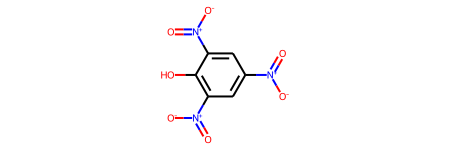

( 1060  /  1086 )...... Spent time: 5.722131967544556
( 1061  /  1086 )...... Spent time: 5.893856763839722
( 1062  /  1086 )...... Spent time: 5.586694955825806
( 1063  /  1086 )...... Spent time: 5.658331632614136
( 1064  /  1086 )...... Spent time: 5.8139355182647705
( 1065  /  1086 )...... Spent time: 5.834949731826782
( 1066  /  1086 )...... Spent time: 6.116064071655273
( 1067  /  1086 )...... Spent time: 5.783259153366089
( 1068  /  1086 )...... Spent time: 5.706749439239502
( 1069  /  1086 )...... Spent time: 5.697253942489624
( 1070  /  1086 )...... Spent time: 5.809084415435791
( 1071  /  1086 )...... Spent time: 5.774572372436523
( 1072  /  1086 )...... Spent time: 5.922079801559448
( 1073  /  1086 )...... Spent time: 5.9200615882873535
( 1074  /  1086 )...... Spent time: 7.485888481140137
( 1075  /  1086 )...... Spent time: 5.921464443206787
( 1076  /  1086 )...... Spent time: 5.8542516231536865
( 1077  /  1086 )...... Spent time: 5.765862464904785
( 1078  /  1086 )...... S

In [20]:
#test:smiles2mol2fingerprint
df_1=pd.read_csv("data_test_reaxys.csv",encoding="gbk")
Reactant_mols = remove_reactant_smiles()
remove_atom_mapping()
n = 50
accuracies = np.empty([0,n])
total_length = len(df_1)
print('total length: ', total_length)

for a,i in enumerate(df_1['Product']):
    curr_time = time.time()
    spent_time = curr_time - start_time
    print('(', a+1, ' / ', total_length, ')......', "Spent time:", spent_time)
    start_time = time.time()
    
    product_smiles = i
    product_mol = Chem.MolFromSmiles(product_smiles)
    product_mfp = AllChem.GetMorganFingerprint(product_mol,2,useFeatures=True)
    #get product_similarity
    s_prods = []
    for i in mfps:
        s_prod = DataStructs.TanimotoSimilarity(product_mfp,i)
        s_prods.append(s_prod)
    #print(s_prods)
    index = np.argsort(s_prods)[::-1]
    #print(index)
    #print(len(index))
    rxn_template = extract_template(df['Rxn'],200)
    try:
        precursors = propose_precursors(rxn_template)
    except:
        continue
    rxns,t = get_rxns()
    order = rank()
    df_2 = pd.read_csv("remove_data_test_reaxys.csv",encoding="gbk")
    true_precursors = df_2['Reactant'][a]
    #true_precursors = df_1['Reactant'][a]
    accuracy = get_accuracy(n)
    accuracies = np.append(accuracies,[accuracy],axis=0)
    if a % int(total_length//20) == 0:
        print(5*a//(total_length//20), "%, ", 'accuracy:', np.mean(accuracies, axis=0))
#print(accuracies)
mean_accuracies = np.mean(accuracies, axis=0)
print(f"Top {n} accuracy: {mean_accuracies[n-1] * 100: .2f} %")